In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from itertools import chain
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder

import pydicom
from skimage import io
from skimage.io import imread, imshow
##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## 1. Import data

In [2]:
## Below is sme helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
25815,00006784_001.png,No Finding,1,6784,28,M,PA,2500,2048,0.168,0.168,NaN
99633,00026387_000.png,Infiltration,0,26387,71,F,PA,2498,2991,0.143,0.143,NaN
36690,00009659_009.png,Atelectasis|Effusion|Pleural_Thickening,9,9659,35,M,PA,2500,2048,0.168,0.168,NaN


In [3]:
#For pixel-level assessment (part 4)

sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3469,00017123_000.png,No Finding,0,17123,041Y,M,PA,2992,2991,0.143,0.143
53,00000272_003.png,No Finding,3,272,031Y,F,PA,2370,2641,0.143,0.143
4594,00022919_002.png,Nodule,2,22919,039Y,F,PA,2554,2991,0.143,0.143


In [4]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [5]:
all_xray_df.drop('Unnamed: 11', axis = 1, inplace = True)

In [6]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


## 2. Preparing data

Here we will separate all labels present in "Finding Labels"

In [7]:
#First, let's separate all labels

unique_labels = all_xray_df['Finding Labels'].unique().tolist()
labels = [unique_labels[i].split('|') for i in range(len(unique_labels))]

all_labels = list(np.unique(list(chain(*labels)))); all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [8]:
def separate_categorical(df, column_name = 'Finding Labels', sep = '|'):
    unique_labels = df[column_name].unique().tolist()
    labels = [unique_labels[i].split(sep) for i in range(len(unique_labels))]
    all_labels = list(np.unique(list(chain(*labels))))
    
    for c_label in all_labels:
         if len(c_label)>1:
            df[c_label] = df[column_name].map(lambda finding: 1.0 if c_label in finding else 0)
    return df, all_labels

In [9]:
all_xray_numeric, all_labels = separate_categorical(all_xray_df)

In [10]:
all_xray_numeric

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 3. EDA

### 3.1 Distribution of diseases

In [11]:
#Number of pneumonia cases

pneumonia_cases = all_xray_numeric.Pneumonia.sum()
non_pneumonia_cases = len(all_xray_numeric) - pneumonia_cases
(pneumonia_cases + non_pneumonia_cases) == len(all_xray_numeric) 

print(f'Pneumonia cases: {pneumonia_cases}\nNo pneumonia cases: {non_pneumonia_cases}')

Pneumonia cases: 1431.0
No pneumonia cases: 110689.0


In [12]:
# Distribution of diseases
all_xray_numeric[all_labels].sum()/len(all_xray_numeric)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

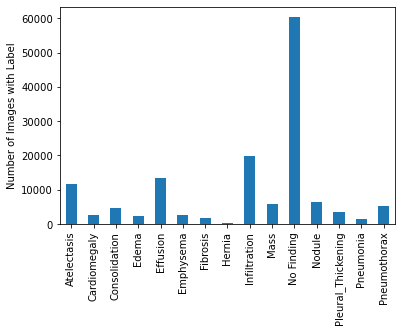

In [13]:
ax = all_xray_numeric[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

We can see here that pneumonia only constitutes 1.2% of the hole dataset. The most common is no-finding (50%) followed by Infiltration, Effusion and Atelectasis. 

### 3.2 The distribution of other diseases that are comorbid with pneumonia

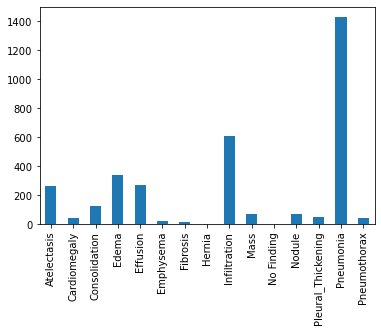

In [14]:
#I now check how many cases are present with pneumonia 
#(The distribution of other diseases that are comorbid with pneumonia)

pneumonia_df = all_xray_numeric[all_xray_numeric['Pneumonia'] == 1]
pneumonia_df[all_labels].sum().plot(kind = 'bar')

Here we can see the distribution of other diseases comorbid with pneumonia. Infiltration is the most common, followed by Edema, Effusion and Atelectasis. It will be interesting to pay attention in the training step to the performance in those cases which present a comorbid disease (specially infiltration)

Also we can plot the most 30 common concurrences: 

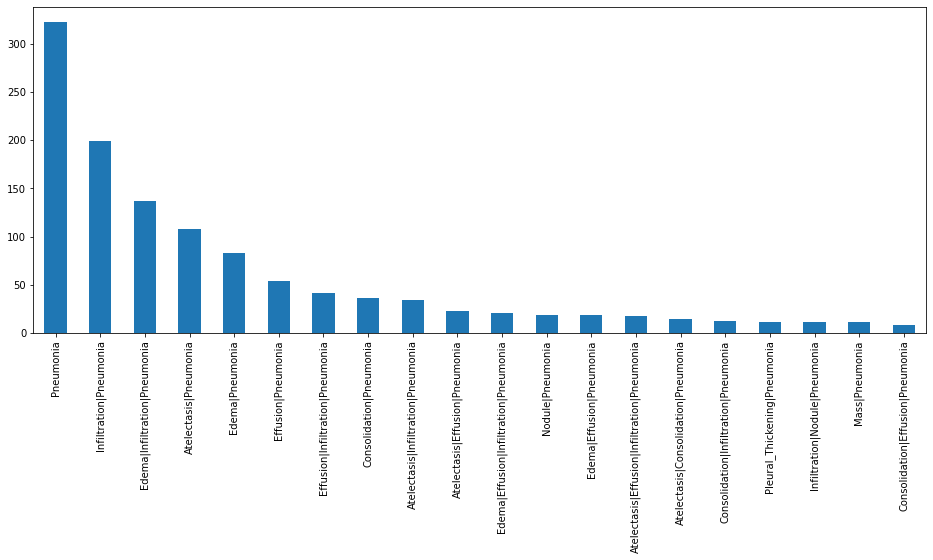

In [15]:
plt.figure(figsize=(16,6))
all_xray_numeric[all_xray_numeric.Pneumonia==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')

### 3.3 Demographics

#### 3.3.1 Gender

For the whole dataset

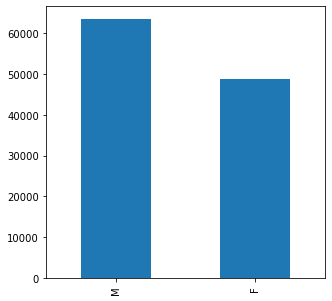

In [16]:
plt.figure(figsize=(5,5))
all_xray_numeric['Patient Gender'].value_counts().plot(kind='bar')

In [17]:
male_ratio = len(all_xray_numeric[all_xray_numeric['Patient Gender'] == 'M'])/len(all_xray_numeric)

In [18]:
fem_ratio = len(all_xray_numeric[all_xray_numeric['Patient Gender'] == 'F'])/len(all_xray_numeric)

In [19]:
male_ratio / fem_ratio

1.2984829848298485

Approximately 3:2 ratio

Only for Pneumonia patients: 

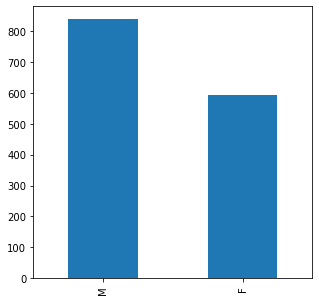

In [20]:
plt.figure(figsize=(5,5))
all_xray_numeric[all_xray_numeric.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')

We see here that there are more male patients than females (male approx a factor 1.3 more than female). This is not a big deal regarding the training

#### 3.3.2 Age

Age distribution:
min = 1
max = 95


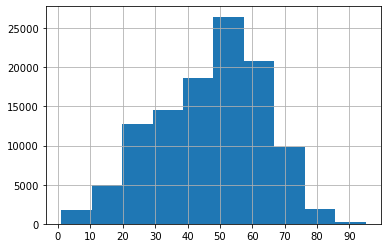

In [21]:
all_xray_numeric[all_xray_numeric['Patient Age']<100]['Patient Age'].hist(bins=10)
plt.xticks(list(range(0,100,10)))
minim = all_xray_numeric[all_xray_numeric['Patient Age']<100]['Patient Age'].min()
maxi = all_xray_numeric[all_xray_numeric['Patient Age']<100]['Patient Age'].max()
print(f'Age distribution:\nmin = {minim}\nmax = {maxi}')

Patients with pneumonia

Age distribution:
min = 2
max = 90


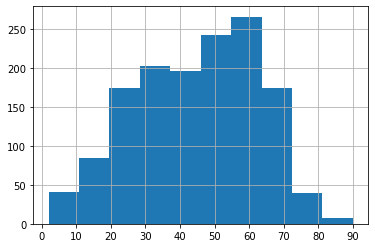

In [22]:
all_xray_numeric[all_xray_numeric['Patient Age']<100]['Patient Age'][all_xray_numeric.Pneumonia ==1].hist(bins=10)
plt.xticks(list(range(0,100,10)))
minim = all_xray_numeric[(all_xray_numeric['Patient Age']<100) & (all_xray_numeric['Pneumonia'] == 1)]['Patient Age'].min()
maxi = all_xray_numeric[(all_xray_numeric['Patient Age']<100) & (all_xray_numeric['Pneumonia'] == 1)]['Patient Age'].max()
print(f'Age distribution:\nmin = {minim}\nmax = {maxi}')

#### 3.3.3 Patient Position

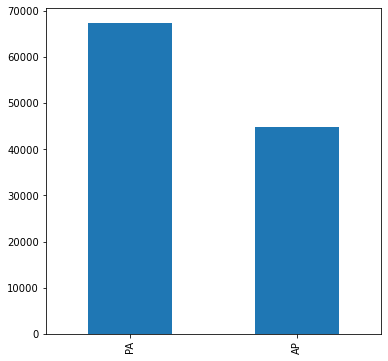

In [23]:
plt.figure(figsize=(6,6))
all_xray_numeric['View Position'].value_counts().plot(kind='bar')

Only with pneumonia

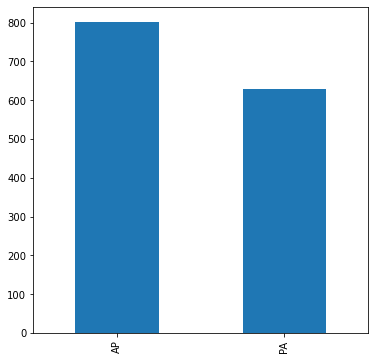

In [24]:
plt.figure(figsize=(6,6))
all_xray_numeric[all_xray_numeric.Pneumonia ==1]['View Position'].value_counts().plot(kind='bar')

in general, there are more PA views than AP. However, for pneumonia cases the dominant view is AP. 

#### 3.3.4 Diseases per patient

This function returns a list (added as a new column to the original dataframe) which contains the number of diseases per patient. However, this code takes so much time because there are so many patients to proceed. Regarding this issue, I will show it as a part of the exercise, but since I consider that this information is not whort it (at least paying the time needed) I won't run the following cells

In [25]:
# Function to obtain number of diseases per patient 

all_xray_numeric.index = all_xray_numeric['Patient ID']

# First we iterate per patient
# We look at the first column (ej: Atelectasis). If there is a "1", print 1, if not, print 0
# Then look at the second column, and do the same. 
# Finally, we sum up all the results. That number is the number of diseasesper patient 

def dis_per_patient(df, labels = all_labels):
    df['Total Diseases'] = 0
    for patient in df['Patient ID'].unique():
        sums = df[df['Patient ID'] == patient][labels].sum()
        total_diseases = np.sum(np.where(sums > 0, 1, sums))
        df.loc[patient, 'Total Diseases'] = total_diseases
    return df

In [26]:
#dis_per_patient_df = dis_per_patient(all_xray_numeric)

In [27]:
#dis = dis_per_patient_df.groupby(by = 'Patient ID', level = 0)['Total Diseases'].value_counts()

## 4. Pixel - level assessments 

Pixel-level assessment of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [28]:
sample_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [29]:
# Separating diseases
sample_num, diseases_labels = separate_categorical(sample_df) #To split diseases

In [30]:
os.listdir('/data')

['FAQ_CHESTXRAY.pdf',
 'ARXIV_V5_CHESTXRAY.pdf',
 'images_009',
 'images_011',
 'images_003',
 'images_004',
 'README_CHESTXRAY.pdf',
 'images_012',
 'images_007',
 'images_005',
 'train_val_list.txt',
 'BBox_List_2017.csv',
 'images_001',
 'images_008',
 'LOG_CHESTXRAY.pdf',
 'images_006',
 'test_list.txt',
 'images_002',
 'images_010',
 'Data_Entry_2017.csv']

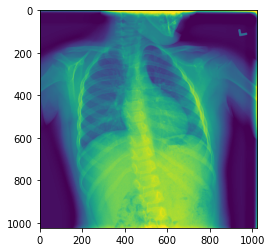

In [31]:
example = plt.imread('/data/images_011/images/00026205_000.png')
plt.imshow(example)

In [32]:
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', sample_num.shape[0])
sample_num['path'] = sample_num['Image Index'].map(all_image_paths.get)
sample_num.sample(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
2602,00013071_004.png,No Finding,4,13071,010Y,F,PA,2570,2773,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_006/images/00013071_004.png
601,00003094_005.png,No Finding,5,3094,053Y,F,PA,2874,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_002/images/00003094_005.png
3973,00019617_001.png,No Finding,1,19617,054Y,F,PA,2710,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_009/images/00019617_001.png


In [33]:
diseases_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [34]:
def image_histogram(index, df, label): 
    path = df.path[index]
    img = io.imread(path)

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    ax[0].imshow(img)
    ax[0].set_title(label)

    ax[1].hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
    ax[1].set_title(f'{label} histogram')


### 4.1 Healthy images

In [35]:
health = sample_num[sample_num['Finding Labels']=='No Finding']
health.reset_index(inplace= True)

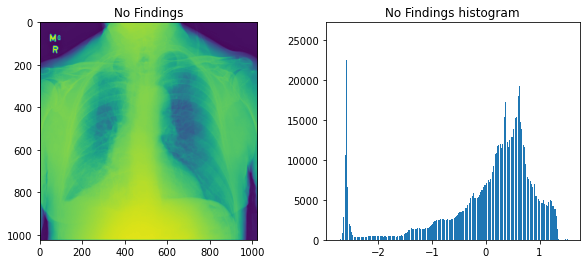

In [36]:
image_histogram(0, health, 'No Findings')

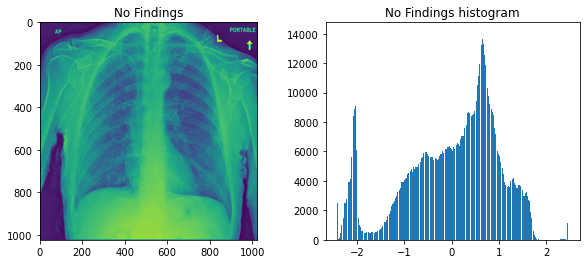

In [37]:
image_histogram(1, health, 'No Findings')

### 4.2 Pneumonia images 

In [38]:
pneumonia = sample_num[sample_num['Pneumonia']==1]
pneumonia.reset_index(inplace= True)

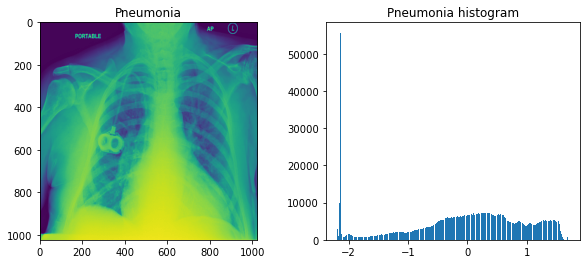

In [39]:
image_histogram(0, pneumonia, 'Pneumonia')

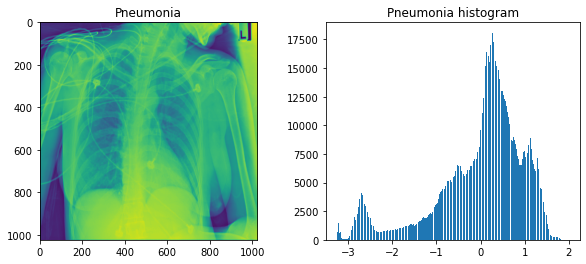

In [40]:
image_histogram(10, pneumonia, 'Pneumonia')

### 4.3 Infiltration

In [41]:
infiltration = sample_num[sample_num['Infiltration']==1]
infiltration.reset_index(inplace= True)

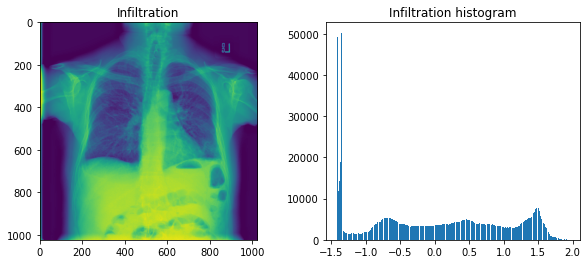

In [42]:
image_histogram(10, infiltration, 'Infiltration')

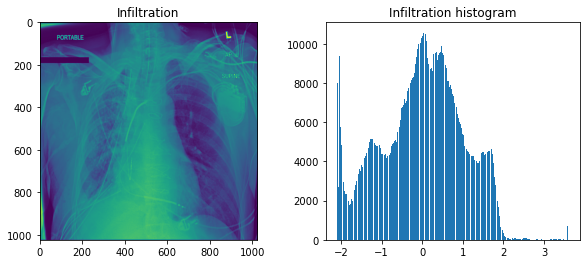

In [43]:
image_histogram(0, infiltration, 'Infiltration')

### 4.4 Atelectasis

In [44]:
atelectasis = sample_num[sample_num['Atelectasis']==1]
atelectasis.reset_index(inplace= True)

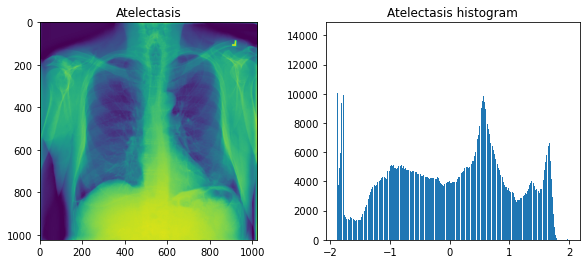

In [45]:
image_histogram(0, atelectasis, 'Atelectasis')

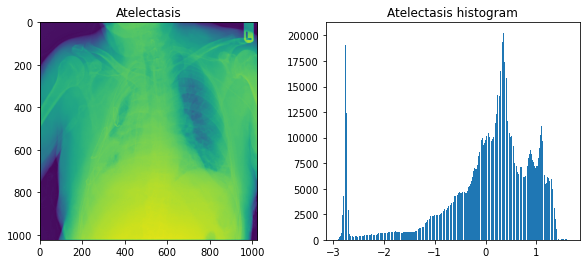

In [46]:
image_histogram(10, atelectasis, 'Atelectasis')

### 4.5 Edema

In [47]:
edema = sample_num[sample_num['Edema']==1]
edema.reset_index(inplace= True)

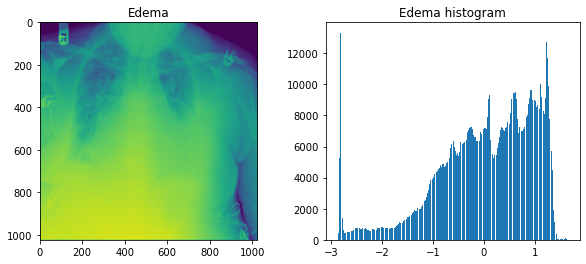

In [48]:
image_histogram(0, edema, 'Edema')

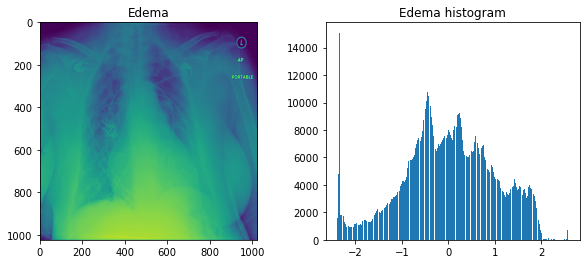

In [49]:
image_histogram(10, edema, 'Edema')

### 4.6 Effusion

In [50]:
effusion = sample_num[sample_num['Effusion']==1]
effusion.reset_index(inplace= True)

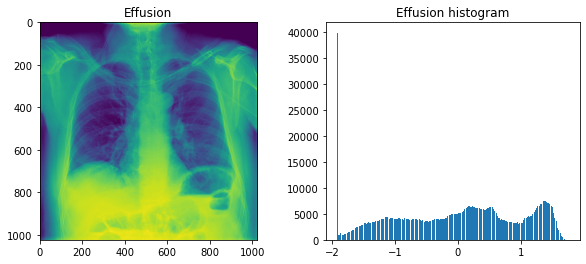

In [51]:
image_histogram(10, effusion, 'Effusion')

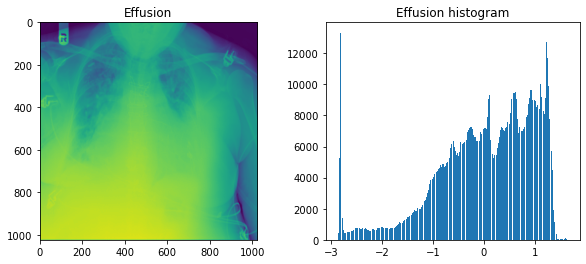

In [52]:
image_histogram(0, effusion, 'Effusion')